## Question 1


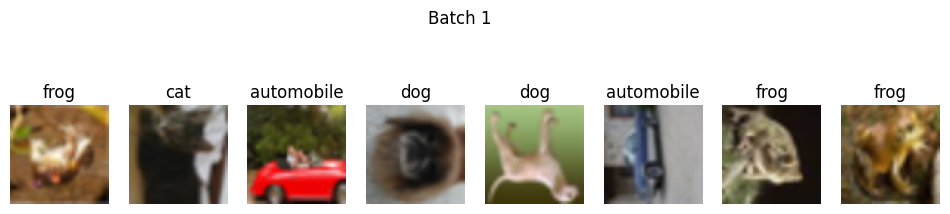

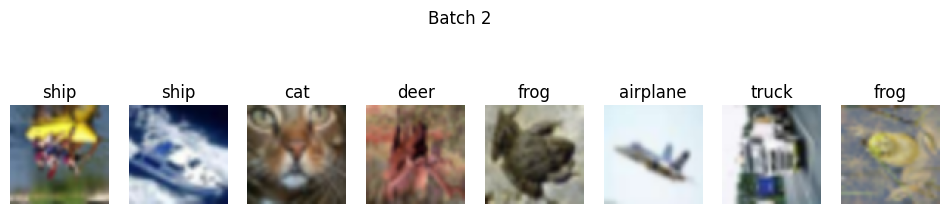

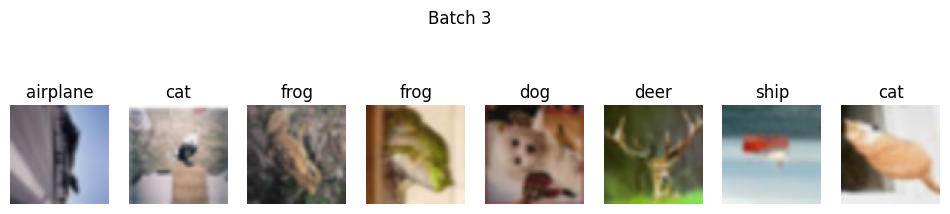

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Reusable Functions ---

def resize_image(img, size=(64, 64)):
    return np.array(Image.fromarray(img).resize(size, Image.BILINEAR))

def random_rotate_90(img):
    k = np.random.choice([0, 1, 2, 3])  # 0, 90, 180, 270 degrees
    return np.rot90(img, k)

def load_image(path):
    img = Image.open(path)
    return np.array(img)

def get_image_paths_labels(folder, labels_csv):
    # Read labels
    labels = {}
    with open(labels_csv, 'r') as f:
        next(f)  # skip header
        for line in f:
            fname, label = line.strip().split(',')
            labels[f"{fname}.png"] = label
            
    # Get image paths and labels
    img_files = sorted(os.listdir(folder))
    img_paths = [os.path.join(folder, fname) for fname in img_files if fname.endswith('.png')]
    img_labels = [labels[fname] for fname in img_files if fname.endswith('.png')]
    return img_paths, img_labels

# --- Dataloader ---

class CIFAR10DataLoader:
    def __init__(self, img_folder, labels_csv, batch_size=8):
        self.img_paths, self.img_labels = get_image_paths_labels(img_folder, labels_csv)
        self.batch_size = batch_size
        self.idx = 0

    def __iter__(self):
        self.idx = 0
        return self

    def __next__(self):
        if self.idx >= len(self.img_paths):
            raise StopIteration
        batch_paths = self.img_paths[self.idx:self.idx+self.batch_size]
        batch_labels = self.img_labels[self.idx:self.idx+self.batch_size]
        batch_imgs = []
        for path in batch_paths:
            img = load_image(path)
            img = resize_image(img, (64, 64))
            img = random_rotate_90(img)
            batch_imgs.append(img)
        self.idx += self.batch_size
        return np.stack(batch_imgs), batch_labels


img_folder = 'data/cifar-10/train/train'
labels_csv = 'data/cifar-10/trainLabels.csv'
batch_size = 8

loader = CIFAR10DataLoader(img_folder, labels_csv, batch_size=batch_size)

# Visualize first 3 batches
for batch_num, (imgs, labels) in enumerate(loader):
    if batch_num >= 3:
        break
    plt.figure(figsize=(12, 3))
    for i in range(len(imgs)):
        plt.subplot(1, batch_size, i+1)
        plt.imshow(imgs[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.suptitle(f'Batch {batch_num+1}')
    plt.show()

## Question 2

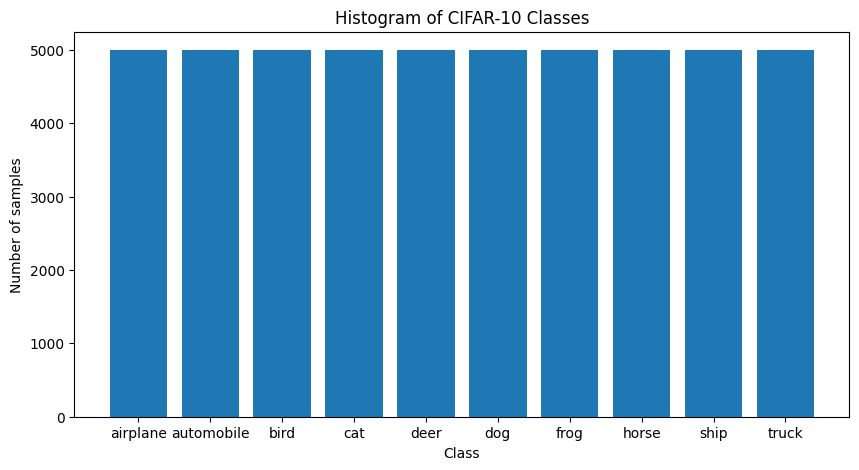

In [ ]:
# Count samples per class
class_counts = {}
with open(labels_csv, 'r') as f:
    next(f)  # skip header
    for line in f:
        fname, label = line.strip().split(',')
        class_counts[label] = class_counts.get(label, 0) + 1

# Plot histogram
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]

plt.figure(figsize=(10,5))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Histogram of CIFAR-10 Classes')
plt.show()

# Comment:
# The bars are of similar height, the dataset is balanced across classes.

## Question 3

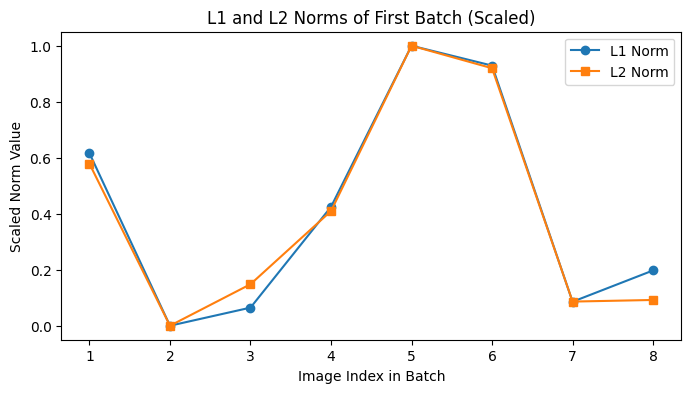

In [12]:
# Get the first batch from the dataloader
loader = CIFAR10DataLoader(img_folder, labels_csv, batch_size=batch_size)
imgs, labels = next(iter(loader))  # imgs shape: (8, 64, 64, 3)

# Compute L1 and L2 norms for each image
l1_norms = [np.linalg.norm(img.flatten().astype(np.float64), ord=1) for img in imgs]
l2_norms = [np.linalg.norm(img.flatten().astype(np.float64), ord=2) for img in imgs]

l1_min, l1_max = min(l1_norms), max(l1_norms)
l1_norms_scaled = [(n - l1_min) / (l1_max - l1_min) if (l1_max - l1_min) != 0 else 0 for n in l1_norms]

l2_min, l2_max = min(l2_norms), max(l2_norms)
l2_norms_scaled = [(n - l2_min) / (l2_max - l2_min) if (l2_max - l2_min) != 0 else 0 for n in l2_norms]

# Visualize
plt.figure(figsize=(8,4))
plt.plot(range(1, 9), l1_norms_scaled, 'o-', label='L1 Norm')
plt.plot(range(1, 9), l2_norms_scaled, 's-', label='L2 Norm')
plt.xlabel('Image Index in Batch')
plt.ylabel('Scaled Norm Value')
plt.title('L1 and L2 Norms of First Batch (Scaled)')
plt.legend()
plt.show()

## Question 4

In [ ]:
# --- Center Crop ---
def center_crop(img, size=(64, 64)):
    h, w = img.shape[:2]
    new_h, new_w = size
    top = (h - new_h) // 2
    left = (w - new_w) // 2
    return img[top:top+new_h, left:left+new_w]

# Load images and labels 
img_folder = 'data/cifar-10/train/train'
labels_csv = 'data/cifar-10/trainLabels.csv'

# Use helper function
img_paths, img_labels = get_image_paths_labels(img_folder, labels_csv)

# Take first 100
img_paths = img_paths[:100]
img_labels = img_labels[:100]

# Map labels to indices
class_names = sorted(list(set(img_labels)))
class_to_idx = {name: i for i, name in enumerate(class_names)}

images = []
labels = []
for path, label in zip(img_paths, img_labels):
    img = load_image(path)           # reuse helper
    img = center_crop(img, (64, 64)) # apply new crop
    images.append(img)
    labels.append(class_to_idx[label])

images = np.array(images)   # (100, 64, 64, 3)
labels = np.array(labels)   # (100,)

# Flatten images 
features = images.reshape(100, -1) / 255.0  # Normalize

# One-hot encode labels 
targets = np.eye(len(class_names))[labels]

# Network 
def relu(x): return np.maximum(0, x)
def sigmoid(x): return 1 / (1 + np.exp(-x))
def tanh(x): return np.tanh(x)

def relu_grad(x): return (x > 0).astype(float)
def sigmoid_grad(x): s = sigmoid(x); return s * (1 - s)
def tanh_grad(x): return 1 - np.tanh(x)**2

activations = {
    'relu': (relu, relu_grad),
    'sigmoid': (sigmoid, sigmoid_grad),
    'tanh': (tanh, tanh_grad)
}

# Initialize weights 
np.random.seed(42)
input_dim = features.shape[1]
W1 = np.random.randn(input_dim, 128) * 0.01
b1 = np.zeros(128)
W2 = np.random.randn(128, 64) * 0.01
b2 = np.zeros(64)
W3 = np.random.randn(64, 10) * 0.01
b3 = np.zeros(10)

lr = 0.01
epochs = 10

for act_name in ['relu', 'sigmoid', 'tanh']:
    act, act_grad = activations[act_name]
    print(f"\nActivation: {act_name.upper()}")

    # Re-initialize weights for each activation
    W1 = np.random.randn(input_dim, 128) * 0.01
    b1 = np.zeros(128)
    W2 = np.random.randn(128, 64) * 0.01
    b2 = np.zeros(64)
    W3 = np.random.randn(64, 10) * 0.01
    b3 = np.zeros(10)
    for epoch in range(epochs):
        # Forward 
        Z1 = features @ W1 + b1
        A1 = act(Z1)
        Z2 = A1 @ W2 + b2
        A2 = act(Z2)
        Z3 = A2 @ W3 + b3
        out = Z3

        # Loss 
        loss = np.mean(np.sum((out - targets)**2, axis=1))
        # Backward 
        d_out = 2 * (out - targets) / out.shape[0]
        dZ3 = d_out 
        dW3 = A2.T @ dZ3
        db3 = np.sum(dZ3, axis=0)

        dA2 = dZ3 @ W3.T
        dZ2 = dA2 * act_grad(Z2)
        dW2 = A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0)

        dA1 = dZ2 @ W2.T
        dZ1 = dA1 * act_grad(Z1)
        dW1 = features.T @ dZ1
        db1 = np.sum(dZ1, axis=0)
        
        # Update 
        W3 -= lr * dW3
        b3 -= lr * db3
        W2 -= lr * dW2
        b2 -= lr * db2
        W1 -= lr * dW1
        b1 -= lr * db1
        print(f"Epoch {epoch+1}: lr={lr:.4f}, loss={loss:.4f}")
    print("Gradient magnitude (final epoch):", np.linalg.norm(dW1) + np.linalg.norm(dW2) + np.linalg.norm(dW3))
    print("----")


Activation: RELU
Epoch 1: lr=0.0100, loss=0.9999
Epoch 2: lr=0.0100, loss=0.9954
Epoch 3: lr=0.0100, loss=0.9911
Epoch 4: lr=0.0100, loss=0.9870
Epoch 5: lr=0.0100, loss=0.9831
Epoch 6: lr=0.0100, loss=0.9792
Epoch 7: lr=0.0100, loss=0.9756
Epoch 8: lr=0.0100, loss=0.9721
Epoch 9: lr=0.0100, loss=0.9687
Epoch 10: lr=0.0100, loss=0.9655
Gradient magnitude (final epoch): 0.08629305882994272
----

Activation: SIGMOID
Epoch 1: lr=0.0100, loss=0.9853
Epoch 2: lr=0.0100, loss=0.9304
Epoch 3: lr=0.0100, loss=0.9064
Epoch 4: lr=0.0100, loss=0.8959
Epoch 5: lr=0.0100, loss=0.8914
Epoch 6: lr=0.0100, loss=0.8894
Epoch 7: lr=0.0100, loss=0.8885
Epoch 8: lr=0.0100, loss=0.8881
Epoch 9: lr=0.0100, loss=0.8879
Epoch 10: lr=0.0100, loss=0.8879
Gradient magnitude (final epoch): 0.0633372963756513
----

Activation: TANH
Epoch 1: lr=0.0100, loss=1.0008
Epoch 2: lr=0.0100, loss=0.9961
Epoch 3: lr=0.0100, loss=0.9916
Epoch 4: lr=0.0100, loss=0.9873
Epoch 5: lr=0.0100, loss=0.9832
Epoch 6: lr=0.0100, loss

## Question 5

Iteration 100: Error is 0.35626706293080534
Iteration 200: Error is 0.35628869582662803
Iteration 300: Error is 0.3557177429656468
Iteration 400: Error is 0.3557177347721393
Iteration 500: Error is 0.3557177347721394


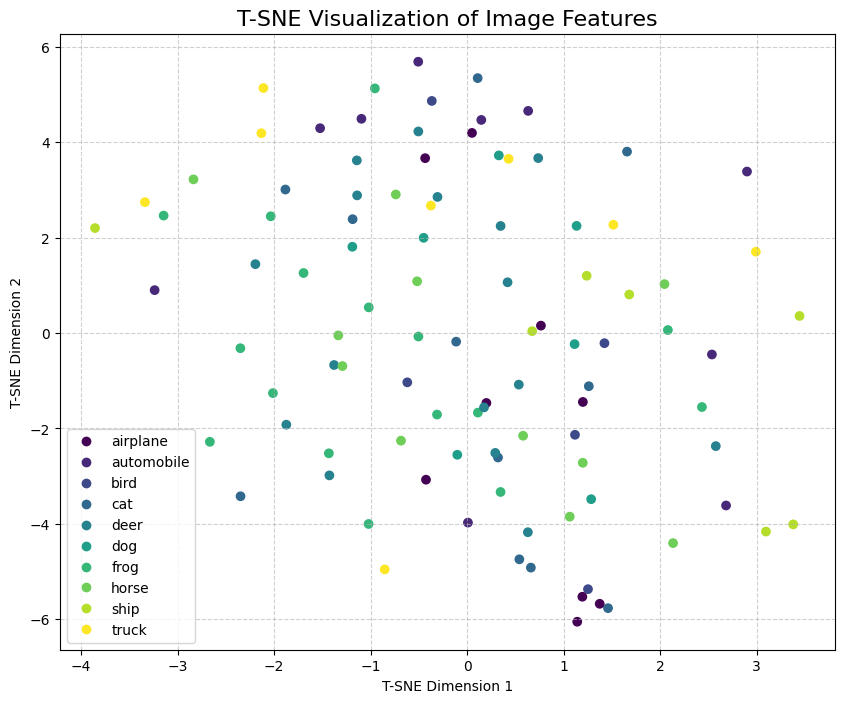

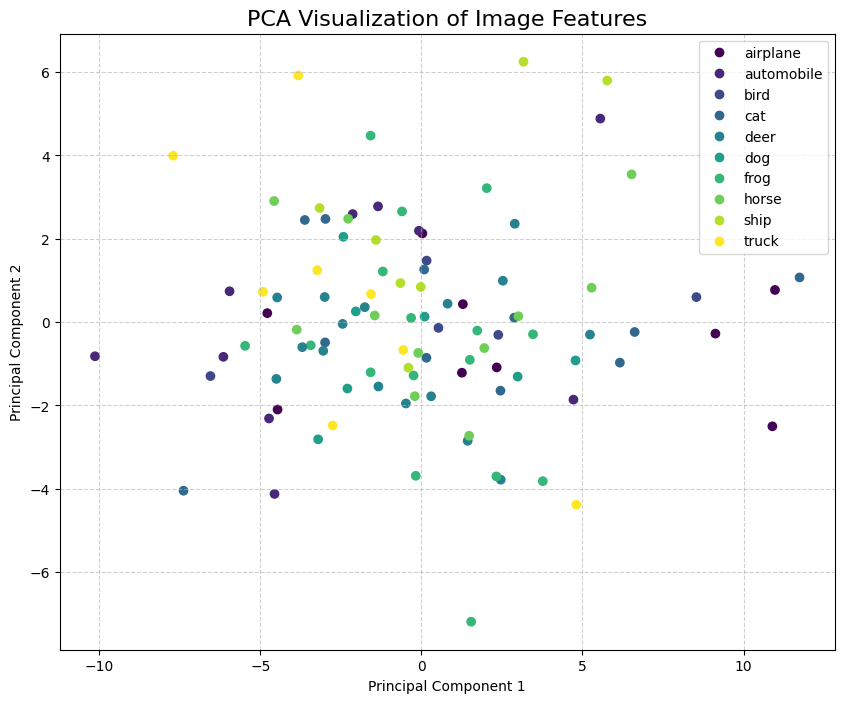

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# T-SNE Implementation 

def Hbeta(D, beta=1.0):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP + 1e-12) + beta * np.sum(D * P) / (sumP + 1e-12)
    P = P / (sumP + 1e-12)
    return H, P

def x2p(X, tol=1e-5, perplexity=30.0):
    n = X.shape[0]
    D = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=2)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):
        betamin = -np.inf
        betamax = np.inf
        Di = np.delete(D[i, :], i)
        H, thisP = Hbeta(Di, beta[i])
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        P[i, np.delete(np.arange(n), i)] = thisP
    return P

def tsne(X, no_dims=2, initial_dims=50, perplexity=30.0, max_iter=500):
    X = PCA(n_components=initial_dims).fit_transform(X)

    n = X.shape[0]
    P = x2p(X, 1e-5, perplexity)
    P = (P + P.T) / (2. * n)
    P = np.maximum(P, 1e-12)

    Y = np.random.randn(n, no_dims)
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))
    
    # Use standard momentum which is more stable
    eta = 500
    min_grad = 1e-7
    
    for i in range(max_iter):
        sum_Y = np.sum(np.square(Y), 1)
        num = 1 / (1 + np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y))
        np.fill_diagonal(num, 0.)
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)
        
        PQ = P - Q
        dY = np.zeros((n, no_dims))
        for j in range(n):
            dY[j, :] = 4 * np.sum(np.tile(PQ[:, j] * num[:, j], (no_dims, 1)).T * (Y[j, :] - Y), 0)
            
        # Standard momentum update
        momentum = 0.5 if i < 250 else 0.8
        iY = momentum * iY - eta * dY
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))
        
        if (i + 1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print(f"Iteration {i + 1}: Error is {C}")
            
    return Y


# T-SNE
Y_tsne = tsne(features, no_dims=2, initial_dims=50, perplexity=30.0, max_iter=500)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=labels, cmap='viridis')
plt.title("T-SNE Visualization of Image Features", fontsize=16)
plt.xlabel("T-SNE Dimension 1")
plt.ylabel("T-SNE Dimension 2")
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# PCA
pca = PCA(n_components=2)
Y_pca = pca.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=labels, cmap='viridis')
plt.title("PCA Visualization of Image Features", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Comparison comment:
# T-SNE typically separates clusters of classes better than PCA, which is linear